# **Perceptrons**
Laboratory 2 of the Machine Learning class by Prof. F. Chiariotti at University of Padova during academic year 2024-2025.

In [1]:
# importing all the necessary python libraries
import numpy as np
import pandas as pd
import random as rnd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

# **Classification of Stayed/Churned Customers**

The Customer Churn table contains information on all 3,758 customers from a Telecommunications company in California in Q2 2022. We want to use this task to predict if a customer will churn (i.e. turn to another company to get a better deal) or not based on three features. It contains three features:
- **Tenure** (in Months) Number of months the customer has stayed with the company
- **Monthly Charge**: The amount charged to the customer monthly
- **Age**: Customer's age
- **Customer Status**:  is 0 if the customer has stayed with the company and 1 if the customer has churned.

In [2]:
np.random.seed(1) # setting the seed

def load_dataset(filename):
    # function that loads the csv file and splits the dataset between input and labels, while also
    # shuffling the data and shifting the label range from [0,1] to [-1,1] (-1 = stayed, +1 = churned)
    data_train = pd.read_csv(filename)
    data_train = data_train.sample(frac=1).reset_index(drop=True) # shuffling
    X = data_train.iloc[:, 0:3].values 
    Y = data_train.iloc[:, 3].values 
    Y = 2*Y-1 #
    return X,Y

# loading the dataset
X, Y = load_dataset('data/telecom_customer_churn_cleaned.csv')

In [3]:
# splitting the data into training and test sets
m_training = int(0.75*X.shape[0]) # computing the split
m_test =  X.shape[0] - m_training
X_training =  X[:m_training] # splitting
Y_training =  Y[:m_training]
X_test =   X[m_training:]
Y_test =  Y[m_training:]
print("# of samples in the train set:", X_training.shape[0])
print("# of samples in the test set:", X_test.shape[0])
print("# of churned users in test:", np.sum(Y_test==-1))
print("# of loyal users in test:", np.sum(Y_test==1))

# standardizing the tests by computing a transformation on the training input set
scaler = preprocessing.StandardScaler().fit(X_training)  
np.set_printoptions(suppress=True) # setting to zero floating point numbers < min_float_eps
# and appling the transformation to both training and test sets
X_training =  scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))
X_test =  scaler.transform(X_test)
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

# of samples in the train set: 2817
# of samples in the test set: 940
# of churned users in test: 479
# of loyal users in test: 461
Mean of the training input data: [-0.  0. -0.]
Std of the training input data: [1. 1. 1.]
Mean of the test input data: [0.0575483  0.05550169 0.0073833 ]
Std of the test input data: [0.98593187 0.97629659 1.00427583]


In [4]:
def to_homogeneous(X_training, X_test):
    # function that transforms from inhomogheneous coordinates to homogeneous ones
    Xh_training = np.hstack([np.ones( (X_training.shape[0], 1) ), X_training])
    Xh_test = np.hstack([np.ones( (X_test.shape[0], 1) ), X_test])
    return Xh_training, Xh_test

X_training, X_test = to_homogeneous(X_training, X_test)
print("some examples of training set in homogeneous coordinates are: ")
print(X_training[:10])

some examples of training set in homogeneous coordinates are: 
[[ 1.         -0.3798618  -1.57020044  0.85174963]
 [ 1.         -0.87925308  0.47180292  1.08667766]
 [ 1.         -0.75440526 -0.6130632  -0.26415851]
 [ 1.         -1.12894873  0.09856916 -0.96894261]
 [ 1.         -1.12894873 -0.58486332 -1.20387064]
 [ 1.          1.78416712  1.39908145  0.08823353]
 [ 1.         -0.7960212  -1.0990965  -0.32289052]
 [ 1.          0.20276137 -0.39907585 -0.96894261]
 [ 1.         -0.62955744  0.63934341  0.96921364]
 [ 1.         -0.87925308  1.13201197 -0.02923048]]


## 1. **Implementing the deterministic perceptron**
The following version of the perceptron is **deterministic** since we used a fixed rule to decide which sample should be considered (e.g. the one with the lowest index).

In [5]:
def count_errors(current_w, X, Y):
    # function that finds all indices which have a different sign from the corresponding labels
    index = np.nonzero(np.sign(np.dot(X, current_w)) - Y)[0]
    n = np.array(index).shape[0]
    if (n == 0): # when there are no misclassified samples
        return 0, -1
    return n, index

def perceptron_fixed_update(current_w, X, Y):
    # function that updates the first misclassified sample based on the first misclassified sample
    new_w=current_w
    n, idx = count_errors(current_w, X, Y)
    if (n > 0):
        new_w = current_w + Y[idx[0]] * X[idx[0],:]    
    return new_w

def perceptron_no_randomization(X, Y, max_num_iterations):
    # function that implements the determistic perceptron on a dataset (X,Y) and
    # imposes a maximum number of iterations as a termination condition 
    num_samples = X.shape[0] # initializing some temporary variables
    num_iter = 0
    curr_w = np.zeros(X.shape[1]) # initializing the perceptron weights
    # computing the initial number of misclassified samples and their indexes
    num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
    best_error = num_misclassified/num_samples # computing the initial error
    best_w = curr_w.copy() # initializing the model
    # iterating until all samples are correctly classified or until the termination condition is met
    while num_misclassified != 0 and num_iter < max_num_iterations:
        curr_w = perceptron_fixed_update(curr_w, X, Y)
        num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
        if num_misclassified / num_samples < best_error:
            # computing the error as the fraction of misclassified samples if a better model is found
            best_error = num_misclassified / num_samples
            best_w = curr_w.copy()
        num_iter += 1
    # returning the best model and the corresponding error
    return best_w, best_error

In [6]:
def loss_estimate(w, X, Y):
    # function that estimates the loss as the fraction of miclassified samples
    err,_ = count_errors(w, X, Y)
    return err / len(Y)

In [7]:
# running the deterministic perceptron for only 30 iterations and later for 100 iterations
w_found, error = perceptron_no_randomization(X_training,Y_training, 30)
w_found2, error2 = perceptron_no_randomization(X_training,Y_training, 100)
print('deterministic perceptron: ')
print("training error after   30 iterations is: ", error)
print("training error after 100 iterations is: ", error2)

# evaluating the performance of the determinstic perceptron on the test set
true_loss_estimate =  loss_estimate(w_found, X_test, Y_test)
true_loss_estimate2 =  loss_estimate(w_found2, X_test, Y_test) 
print("test error after   30 iterations: ", true_loss_estimate)
print("test error after 100 iterations: ", true_loss_estimate2)

deterministic perceptron: 
training error after   30 iterations is:  0.2751153709620163
training error after 100 iterations is:  0.2751153709620163
test error after   30 iterations:  0.26382978723404255
test error after 100 iterations:  0.26382978723404255


## 2. **Implementing the random perceptron**
In following implementation of the perceptron, the choice of which sample should be considered is random.

In [8]:
def perceptron_randomized_update(current_w, X, Y):
    # function that updates the perceptron weights
    new_w=current_w
    n, idx = count_errors(current_w, X, Y)
    # Choose a random misclassified sample
    if (n > 0):
        chosen = rnd.sample(sorted(idx), 1)[0]
        new_w = current_w + Y[chosen] * X[chosen,:]
    return new_w

def perceptron_with_randomization(X, Y, max_num_iterations):
    # function that implements the random perceptron on a dataset (X,Y) and
    # imposes a maximum number of iterations as a termination condition 
    num_samples = X.shape[0] # initializing support variables
    num_iter = 0
    curr_w = np.zeros(X.shape[1]) # initializing the perceptron weights 
    # compute the number of misclassified samples and their indexes
    num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
    best_error = num_misclassified / num_samples # computing the initial error
    best_w = curr_w.copy() # initalizing the model
    # iterating until all samples are correctly classified or until the termination condition is met
    while num_misclassified != 0 and num_iter < max_num_iterations:
        curr_w = perceptron_randomized_update(curr_w, X, Y)
        num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
        if num_misclassified / num_samples < best_error:
            # computing the error as the fraction of misclassified samples if a better model is found
            best_error = num_misclassified / num_samples
            best_w = curr_w.copy()
        num_iter += 1
    # returning the best model and the corresponding error
    return best_w, best_error

Now test the correct version of the perceptron using 30 iterations and print the error of the best model we have found.

In [9]:
# running the random perceptron for only 30 iterations and later for 100 iterations
w_found, error = perceptron_with_randomization(X_training, Y_training, 30)
w_found2, error2 = perceptron_with_randomization(X_training, Y_training, 100)
print('random perceptron')
print("training error after   30 iterations: ", error)
print("training error after 100 iterations: ", error2)

# evaluating the performance of the determinstic perceptron on the test set
true_loss_estimate =  loss_estimate(w_found, X_test, Y_test)
true_loss_estimate2 =  loss_estimate(w_found2, X_test, Y_test) 
print("test error after   30 iterations: ", true_loss_estimate)
print("test error after 100 iterations: ", true_loss_estimate2)

random perceptron
training error after   30 iterations:  0.273340433084842
training error after 100 iterations:  0.2499112531061413
test error after   30 iterations:  0.2702127659574468
test error after 100 iterations:  0.26276595744680853


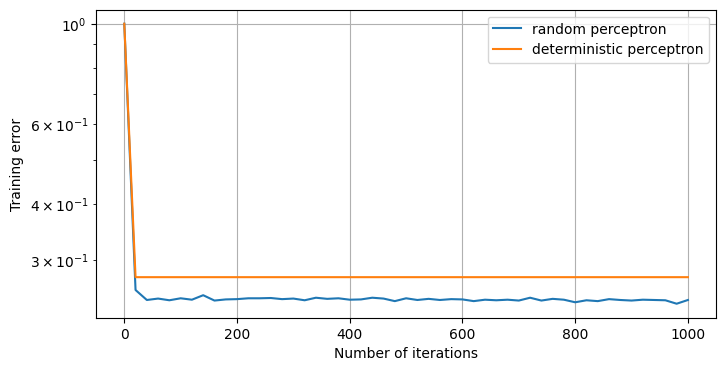

In [10]:
# plotting and comparing the training losses with respect to the number of iterations

num_iters = np.arange(0, 1001,20) # initializing
errors_rand = []
errors_det = []

for num_iter in num_iters: 
    _, error_rand = perceptron_with_randomization(X_training, Y_training, num_iter)
    _, error_det = perceptron_no_randomization(X_training, Y_training, num_iter)
    errors_rand.append(error_rand)
    errors_det.append(error_det)

plt.figure(figsize=(8,4))
plt.plot(num_iters, errors_rand, label='random perceptron')
plt.plot(num_iters, errors_det, label='deterministic perceptron')
plt.xlabel('Number of iterations')
plt.ylabel('Training error')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()